In [1]:
import os
import sys

import numpy as np
from pstools.rambo import dot
from nntools.model import Model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# choose the number of training points (will later be split into NN train/test set)
delta_cut = 0.03
n_final = 3

In [3]:
momenta = np.load("data/NJfks_ee"+str(n_final)+"j_tree_momenta_"+str(delta_cut)+".npy")
NJ_treevals = np.load("data/NJfks_ee"+str(n_final)+"j_tree_values_"+str(delta_cut)+".npy")

In [4]:
n_training_points = len(momenta)

In [5]:
newmomenta = np.load("data/NJfks_ee"+str(n_final)+"j_tree_momenta_"+str(delta_cut)+"_testset.npy")
NJ_treevals_test = np.load("data/NJfks_ee"+str(n_final)+"j_tree_values_"+str(delta_cut)+"_testset.npy")

In [6]:
n_points = len(newmomenta)

In [7]:
def getFKSpartitions(mom):
    nn = len(mom)
    ss = [];
    for i in range(2,nn-1):
        for j in range(i+1,nn):
            #print(i, j, i-2+(j-2)*(j-3)/2)
            ss.append(2*dot(mom[i],mom[j]))
    ss = np.array(ss)
    DD = np.sum(1/ss)
    SS = 1/ss/DD
    return(SS)

In [8]:
parts = getFKSpartitions(momenta[3])
n_FKSsectors = len(parts)

print(parts)
print(np.sum(parts))

[0.02167698 0.9430576  0.03526542]
1.0


In [9]:
NJ_treevals_FKS = []
momenta_FKS = []
for pt in range(n_training_points):
    parts = getFKSpartitions(momenta[pt])
    momenta_FKS.append(parts)
    NJ_treevals_FKS.append(NJ_treevals[pt]*parts)

momenta_FKS = np.array(momenta_FKS)
NJ_treevals_FKS = np.array(NJ_treevals_FKS)

# First train a basic or "naive" single model to test against #

In [10]:
NN = Model(
    (2+n_final)*4, # train with all momenta components 
    momenta[:n_training_points], # input data from Rambo PS generator
    np.array(NJ_treevals) # data points from NJet evaluations
)

In [11]:
model, x_mean, x_std, y_mean, y_std = NN.fit(layers=[16,32,16], epoch_interval=100)

processing training data using scaling =  standardise
The training dataset has size (8000, 20)
Epoch 1/10000
8000/8000 [==============================] - 1s 116us/sample - loss: 1.2232 - val_loss: 0.7192
Epoch 101/10000
8000/8000 [==============================] - 0s 11us/sample - loss: 0.1782 - val_loss: 0.0976
Epoch 201/10000
8000/8000 [==============================] - 0s 11us/sample - loss: 0.0655 - val_loss: 0.0669
Epoch 301/10000
8000/8000 [==============================] - 0s 11us/sample - loss: 0.0476 - val_loss: 0.0478
Epoch 401/10000
8000/8000 [==============================] - 0s 11us/sample - loss: 0.0268 - val_loss: 0.0481


# Now train each FKS partition separately #

In [12]:
NN_FKS = [Model(
    (2+n_final)*4, # train with all momenta components 
    momenta[:n_training_points], # input data from Rambo PS generator
    np.array(NJ_treevals_FKS[:,i]) # data points from NJet evaluations
) for i in range(n_FKSsectors)]

NNfitdata_FKS = [NN_FKS[i].fit(layers=[16,32,16], epoch_interval=100) for i in range(n_FKSsectors)]

processing training data using scaling =  standardise
The training dataset has size (8000, 20)
Epoch 1/10000
8000/8000 [==============================] - 1s 112us/sample - loss: 1.0196 - val_loss: 0.7423
Epoch 101/10000
8000/8000 [==============================] - 0s 10us/sample - loss: 0.0351 - val_loss: 0.0307
Epoch 201/10000
8000/8000 [==============================] - 0s 10us/sample - loss: 0.0116 - val_loss: 0.0140
Epoch 301/10000
8000/8000 [==============================] - 0s 10us/sample - loss: 0.0098 - val_loss: 0.0128
Epoch 401/10000
8000/8000 [==============================] - 0s 10us/sample - loss: 0.0057 - val_loss: 0.0061
Epoch 501/10000
8000/8000 [==============================] - 0s 11us/sample - loss: 0.0065 - val_loss: 0.0075
Epoch 601/10000
8000/8000 [==============================] - 0s 10us/sample - loss: 0.0027 - val_loss: 0.0069
Epoch 701/10000
8000/8000 [==============================] - 0s 10us/sample - loss: 0.0080 - val_loss: 0.0078
processing training data u

# test models against some new data points #

In [13]:
# predict values with single network
x_standardized = NN.process_testing_data(moms=newmomenta,
                                         x_mean=x_mean,x_std=x_std,y_mean=y_mean,y_std=y_std)
mpred = model.predict(x_standardized)
amp_pred = NN.destandardise_data(mpred.reshape(-1),
                                 x_mean=x_mean,x_std=x_std,y_mean=y_mean,y_std=y_std)

In [14]:
# predict values with FKS networks
amp_pred_FKS = []

for i in range(n_FKSsectors):
    model_tmp = NNfitdata_FKS[i][0]
    x_m = NNfitdata_FKS[i][1]
    x_s = NNfitdata_FKS[i][2]
    y_m = NNfitdata_FKS[i][3]
    y_s = NNfitdata_FKS[i][4]
    
    x_standardized = NN_FKS[i].process_testing_data(moms=newmomenta,
                                         x_mean=x_m,x_std=x_s,y_mean=y_m,y_std=y_s)
    mpred = model_tmp.predict(x_standardized)
    amp_pred_FKS.append(NN_FKS[i].destandardise_data(mpred.reshape(-1),
                                 x_mean=x_m,x_std=x_s,y_mean=y_m,y_std=y_s))
    
amp_pred_FKS = np.array(amp_pred_FKS)

In [15]:
amp_pred_FKS_sum = np.sum(amp_pred_FKS,axis=0)

In [16]:
print(NJ_treevals_test[0:5])
print(amp_pred[0:5])
print(amp_pred_FKS_sum[0:5])

[0.15622687 0.00434912 0.00683187 0.00353451 0.00580646]
[0.18082303 0.01159513 0.01806721 0.01003034 0.00969046]
[0.19270259 0.00209349 0.00632431 0.00150273 0.00334784]


In [17]:
part = getFKSpartitions(newmomenta[0])
print(NJ_treevals_test[0]*part)
print([amp_pred_FKS[i,0] for i in range(n_FKSsectors)])

[0.00687733 0.12295281 0.02639673]
[0.00682129, 0.15714514, 0.028736152]


In [18]:
diff = (amp_pred-np.array(NJ_treevals_test))/(amp_pred+np.array(NJ_treevals_test))
diff_FKS = (amp_pred_FKS_sum-np.array(NJ_treevals_test))/(amp_pred_FKS_sum+np.array(NJ_treevals_test))

In [19]:
mybins = np.histogram_bin_edges(diff, bins=200, range=(-1.5,1.5))

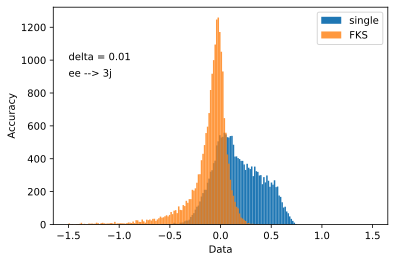

In [20]:
plt.hist(diff, density=False, bins=mybins, label='single')
plt.hist(diff_FKS, density=False, bins=mybins, label='FKS', alpha=0.8)
plt.ylabel('Accuracy')
plt.xlabel('Data')
plt.text(-1.5,1000,'delta = '+str(delta_cut))
plt.text(-1.5,900,'ee --> '+str(n_final)+'j')
plt.legend()

In [21]:
logdiff = np.log10(np.abs(diff))
logdiff_FKS = np.log10(np.abs(diff_FKS))

In [22]:
mybins = np.histogram_bin_edges(logdiff, bins=200, range=(-4,1))

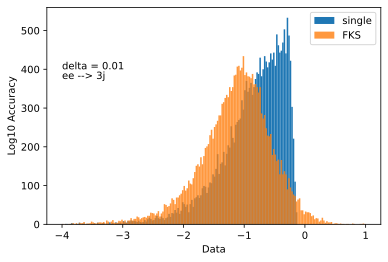

In [23]:
plt.hist(logdiff, density=False, bins=mybins, label='single')
plt.hist(logdiff_FKS, density=False, bins=mybins, label='FKS', alpha=0.8)
plt.ylabel('Log10 Accuracy')
plt.xlabel('Data')
plt.text(-4,400,'delta = '+str(delta_cut))
plt.text(-4,375,'ee --> '+str(n_final)+'j')
plt.legend()

## Exercises ##

1. Checking the cross section predicitions:

   1. Order the inference test data (i.e. NJ_treevals_test from the data set momenta_test) by the size to see which points give the largest contributions to the cross section. 
   
   2. Compare these points (say the largest 10 values) against the inferred values from the single and FKS ensemble networks.
   
   3. Compute the cross section from all three approaches and see which one gave the best approximation

# Example response #

In [24]:
NJmaxvalues = np.sort(NJ_treevals_test)[-10:]
print(NJmaxvalues)

[ 5.92051542  6.61778464  6.67643828  7.35551041  8.03473146  9.77488086
 11.6760958  11.79681226 15.96102144 17.12096974]


In [25]:
for i in range(len(NJmaxvalues)):
    pos = np.where(NJ_treevals_test==NJmaxvalues[i])[0][0]
    print(NJ_treevals_test[pos], amp_pred[pos], amp_pred_FKS_sum[pos])

5.920515422725318 4.2037044 5.270898
6.617784635941985 4.848531 5.1039624
6.6764382815956065 4.3443894 5.4110065
7.35551041016074 5.1120157 4.7869368
8.034731463260187 5.16533 5.3257513
9.774880863905366 6.0076065 6.4915786
11.676095802687815 6.0213227 7.504664
11.796812255794565 4.5777564 5.9419384
15.96102144353514 5.9522305 6.0018005
17.120969741495912 6.084548 7.717679


In [26]:
[[NJ_treevals_test[pos],amp_pred[pos], amp_pred_FKS_sum[pos]] for pos in np.argsort(NJ_treevals_test)[-10:]]

[[5.920515422725318, 4.2037044, 5.270898],
 [6.617784635941985, 4.848531, 5.1039624],
 [6.6764382815956065, 4.3443894, 5.4110065],
 [7.35551041016074, 5.1120157, 4.7869368],
 [8.034731463260187, 5.16533, 5.3257513],
 [9.774880863905366, 6.0076065, 6.4915786],
 [11.676095802687815, 6.0213227, 7.504664],
 [11.796812255794565, 4.5777564, 5.9419384],
 [15.96102144353514, 5.9522305, 6.0018005],
 [17.120969741495912, 6.084548, 7.717679]]

In [27]:
print("'true' results from NJet sigma = ", np.sum(NJ_treevals_test)/n_points)
print("predicted results from single NN = ", np.sum(amp_pred)/n_points)
print("predicted results from FKS NN = ", np.sum(amp_pred_FKS_sum)/n_points)

'true' results from NJet sigma =  0.06594192926357813
predicted results from single NN =  0.06620823974609374
predicted results from FKS NN =  0.061499853515625
